<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-constants-and-define-functions" data-toc-modified-id="Set-constants-and-define-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set constants and define functions</a></span></li><li><span><a href="#Load-and-clean-data" data-toc-modified-id="Load-and-clean-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and clean data</a></span></li><li><span><a href="#&quot;Looks-Good&quot;-responses" data-toc-modified-id="&quot;Looks-Good&quot;-responses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>"Looks Good" responses</a></span><ul class="toc-item"><li><span><a href="#Percentage-of-&quot;Looks-Good&quot;-ratings-at-each-rounding-threshold" data-toc-modified-id="Percentage-of-&quot;Looks-Good&quot;-ratings-at-each-rounding-threshold-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Percentage of "Looks Good" ratings at each rounding threshold</a></span></li><li><span><a href="#Switching-threshold-from-&quot;Too-precise&quot;-to-&quot;Looks-good&quot;-and-from-&quot;Looks-good&quot;-to-&quot;Too-round&quot;" data-toc-modified-id="Switching-threshold-from-&quot;Too-precise&quot;-to-&quot;Looks-good&quot;-and-from-&quot;Looks-good&quot;-to-&quot;Too-round&quot;-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Switching threshold from "Too precise" to "Looks good" and from "Looks good" to "Too round"</a></span></li></ul></li><li><span><a href="#Additional-Analyses" data-toc-modified-id="Additional-Analyses-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Additional Analyses</a></span><ul class="toc-item"><li><span><a href="#Is-5-special-as-a-last-leading-digit?" data-toc-modified-id="Is-5-special-as-a-last-leading-digit?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Is 5 special as a last leading digit?</a></span></li></ul></li></ul></div>

# Round numbers rating Survey 1: 80 participants
This notebook is supplementary material for paper submission. All the ID codes shown in the notebook (e.g., worker ID, HIT ID, assignment ID) have been anonymized.

## Set constants and define functions

In [1]:
library(DT)
library(tidyverse)
library(lubridate)
library(knitr)
library(scales)
library(broom)
library(effectsize)
library(tidyr)
library(comprehenr)
library(dplyr)
library(lmerTest)
library(MuMIn)
library(glmnet)
library(sjPlot)
library(IRdisplay)
library(ggeffects)
knitr::opts_chunk$set(fig.width=15, fig.height=12) 

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.7
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Registered S3 methods overwritten by 'parameters':
  method                           from      
  as.double.parameters_kurtosis    datawizard
  as.double.parameters_skewness    datawizard
  as.double.paramete

First we read the data file and do some initial processing to:
* Replace the options `too-precise`, `looks-good`, `too-round` with the numbers 1, 2 and 3 respectively.
* Convert the data format from long to wide

In [2]:
# set style
theme_set(theme_bw())

study_date <- "20210810"
n_tasks <- 15
n_options <- 10
number_lengths <- c(4, 6, 7, 8, 10)

# helper function to display table in html format
display_table <- function(table) {
    table %>% kable("html") %>% as.character() %>% display_html()
}

read_mturk_data <- function(filename) {
    df <- read.csv(filename, stringsAsFactors=FALSE)
    # replace options with numeric values
    df[df == "too-precise"] <- 1
    df[df == "looks-good"] <- 2
    df[df == "too-round"] <- 3
    df
}

get_sentence_context <- function(sent) {
    if (grepl("the hospital group", sent)) {
        "Money"
    } else if (grepl("DNA evidence", sent)) {
        "People"
    } else {
        "Size"
    }
}

get_sentence_context <- Vectorize(get_sentence_context)

build_wide_data <- function(df) {
    # convert from long to wide format
    df <- df %>%
        filter(!variable %in% c("studyId", "workerId")) %>%
        pivot_wider(id_cols = c("hit_id", "assignment_id", "worker_id"), names_from = "variable", values_from = "value")
    # fill in missing columns to standardize the columns across studies
    # assume each task has at most 10 options
    for (task_num in 1:n_tasks) {
        for (option_num in 1:n_options) {
            number_col <- sprintf("task%d_option%d_number", task_num, option_num)
            rating_col <- sprintf("task%d_option%d_rating", task_num, option_num)
            if (!number_col %in% names(df)) {
                df <- df %>% mutate(!!number_col := NA, !!rating_col := NA)
            }
        }
    }   
    # extract the context from the template sentences
    for (task_num in 1:n_tasks) {
        template_col <- sprintf("task%d_template", task_num)
        context_col <- sprintf("task%d_context", task_num)
        df <- df %>% mutate(!!context_col := get_sentence_context(df[[template_col]]))
    }
    # arrange the columns based on the task and option ordering
    task_option_cols <- to_vec(
        for (task_num in 1:n_tasks)
            for (option_num in 1:n_options)
                c(sprintf("task%d_option%d_number", task_num, option_num), sprintf("task%d_option%d_rating", task_num, option_num))
    )
    # select relevant columns for analyses
    start_time_cols = to_vec(for (task_num in 1:n_tasks) sprintf("task%d_start_time", task_num))
    context_cols = to_vec(for (task_num in 1:n_tasks) sprintf("task%d_context", task_num))
    given_num_cols = to_vec(for (task_num in 1:n_tasks) sprintf("task%d_given_number", task_num))
    df %>% select(
        "hit_id", "assignment_id", "worker_id", "finish_time", "submit_time",
        all_of(given_num_cols), all_of(task_option_cols), all_of(context_cols), all_of(start_time_cols)
    )
}
                            
text_setting <- function(){
    theme(
        axis.title.y = element_text(size = 16),
        axis.text.y = element_text(size = 16),
        axis.text.x = element_text(size = 16),
        text = element_text(size = 16)
    )
}

## Load and clean data

In [3]:
df_raw <- read_mturk_data(sprintf("data/anon_rating_mturk_data_%s.csv", study_date))
df_wide <- build_wide_data(df_raw)

We generate a csv file that assigns the qualification `taken-round-numbers-ratings-2021` to the current workers, so that they will not be included in future studies.

In [4]:
df_wide %>%
    rename(WorkerId = worker_id) %>%
    select(WorkerId) %>% 
    mutate(`UPDATE-taken-round-numbers-rating-2021` = 1) %>%
    write_csv("data/mturk_quals_toupload.csv")

For each participant and each task, we check whether their answers to that task are sensible (i.e., following the order of "too-precise", "looks-good", "too-round")

In [5]:
check_sensible_options <- function(row) {
    row <- row %>% as.numeric() %>% na.omit()
    sorted_row <- row %>% sort(decreasing = FALSE)
    as.numeric(all(row == sorted_row))
}

for (task_num in 1:n_tasks) {
    sensible_col <- sprintf("task%d_sensible", task_num)
    matcher <- sprintf("task%d_option[1-9]0*_rating", task_num)
    df_wide <- df_wide %>% mutate(!!sensible_col := df_wide %>% select(matches(matcher)) %>% apply(1, check_sensible_options))
}

df_wide <- df_wide %>% mutate(n_sensibles = df_wide %>% select(matches("sensible")) %>% rowSums())

We plot the number of sensible tasks for each participant:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



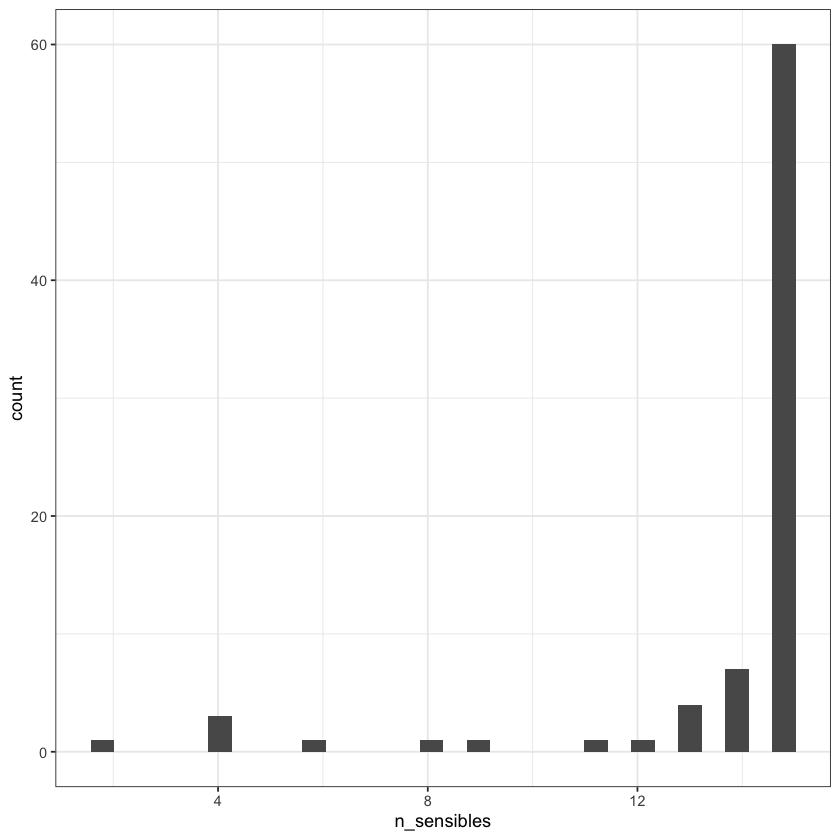

In [6]:
df_wide %>% ggplot(aes(x = n_sensibles)) + geom_histogram()

From this point, we will remove participants who have fewer than 12 sensible task responses.

In [7]:
removed_participants <- df_wide %>% filter(n_sensibles < 12) %>% select(worker_id)
df_raw <- df_raw %>% anti_join(removed_participants)
df_wide <- df_wide %>% anti_join(removed_participants)

print(sprintf("Final sample size: %d", df_wide %>% nrow()))

Joining, by = "worker_id"

Joining, by = "worker_id"



[1] "Final sample size: 72"


We also build a long representation of the data, where each row corresponds to a single rating in a task.

In [8]:
pretty_number_to_float <- function(s) {
    multiplier <- 1
    if (grepl('million$', s)) {
        multiplier <- 1e6
    }
    if (grepl('billion$', s)) {
        multiplier <- 1e9
    }
    s <- gsub('[,a-z ]', '', s)
    as.numeric(s) * multiplier
}

pretty_number_to_float <- Vectorize(pretty_number_to_float)

build_long_data <- function(ratings_from_mturk) {
    ratings_with_split_variable <- ratings_from_mturk %>%
        separate(variable, into = c('task_index', 'option_index', 'number_or_rating'), sep = '_')

    task_option_rating <- ratings_with_split_variable %>%
          filter(grepl('option', option_index)) %>%
          mutate(task_index = as.numeric(gsub('task', '', task_index)),
                 option_index = as.numeric(gsub('option', '', option_index))) %>%
          pivot_wider(names_from = number_or_rating, values_from = value)

    template_given <- ratings_with_split_variable %>%
      filter(option_index %in% c("template", "given")) %>%
      mutate(task_index = as.numeric(gsub('task', '', task_index))) %>%
      select(-number_or_rating) %>%
      pivot_wider(names_from = option_index, values_from = value) %>%
      rename(full_given_number = given)

    # count number of non-zero leading digits
    # h/t to https://stackoverflow.com/a/49024636
    task_option_rating %>% 
        inner_join(template_given) %>%
        mutate(
          number = pretty_number_to_float(number),
          full_given_number = pretty_number_to_float(full_given_number),
          full_length = ceiling(log10(full_given_number)),
          prefix = gsub('0*$', '', sprintf('%.0f', number)),
          prefix_length = nchar(prefix)
        )
}

df_long <- build_long_data(df_raw)

Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 1368 rows [1, 2, 3, 4, 6, 21, 32, 47, 70, 93, 110, 129, 146, 163, 174, 191, 206, 229, 240, 254, ...].”
Joining, by = c("hit_id", "assignment_id", "worker_id", "task_index")



Now we incorporate the sensible task checking into this long dataset and exclude all the tasks whose response are not sensible.

In [9]:
df_sensible <- df_wide %>%
    pivot_longer(cols = task1_sensible:task15_sensible, names_pattern = "task([0-9]+)_sensible", names_to = "task_index", values_to = "is_sensible") %>%
    mutate(task_index = as.numeric(task_index)) %>%
    select(hit_id, assignment_id, worker_id, task_index, is_sensible)

df_long <- df_long %>% inner_join(df_sensible) %>% filter(is_sensible == 1)

Joining, by = c("hit_id", "assignment_id", "worker_id", "task_index")



In [10]:
sum(df_wide$n_sensibles)

[1] 1062

## "Looks Good" responses

### Percentage of "Looks Good" ratings at each rounding threshold

The following graph breaks down by number length and context.

`summarise()` has grouped output by 'prefix_length', 'full_length'. You can override using the `.groups` argument.



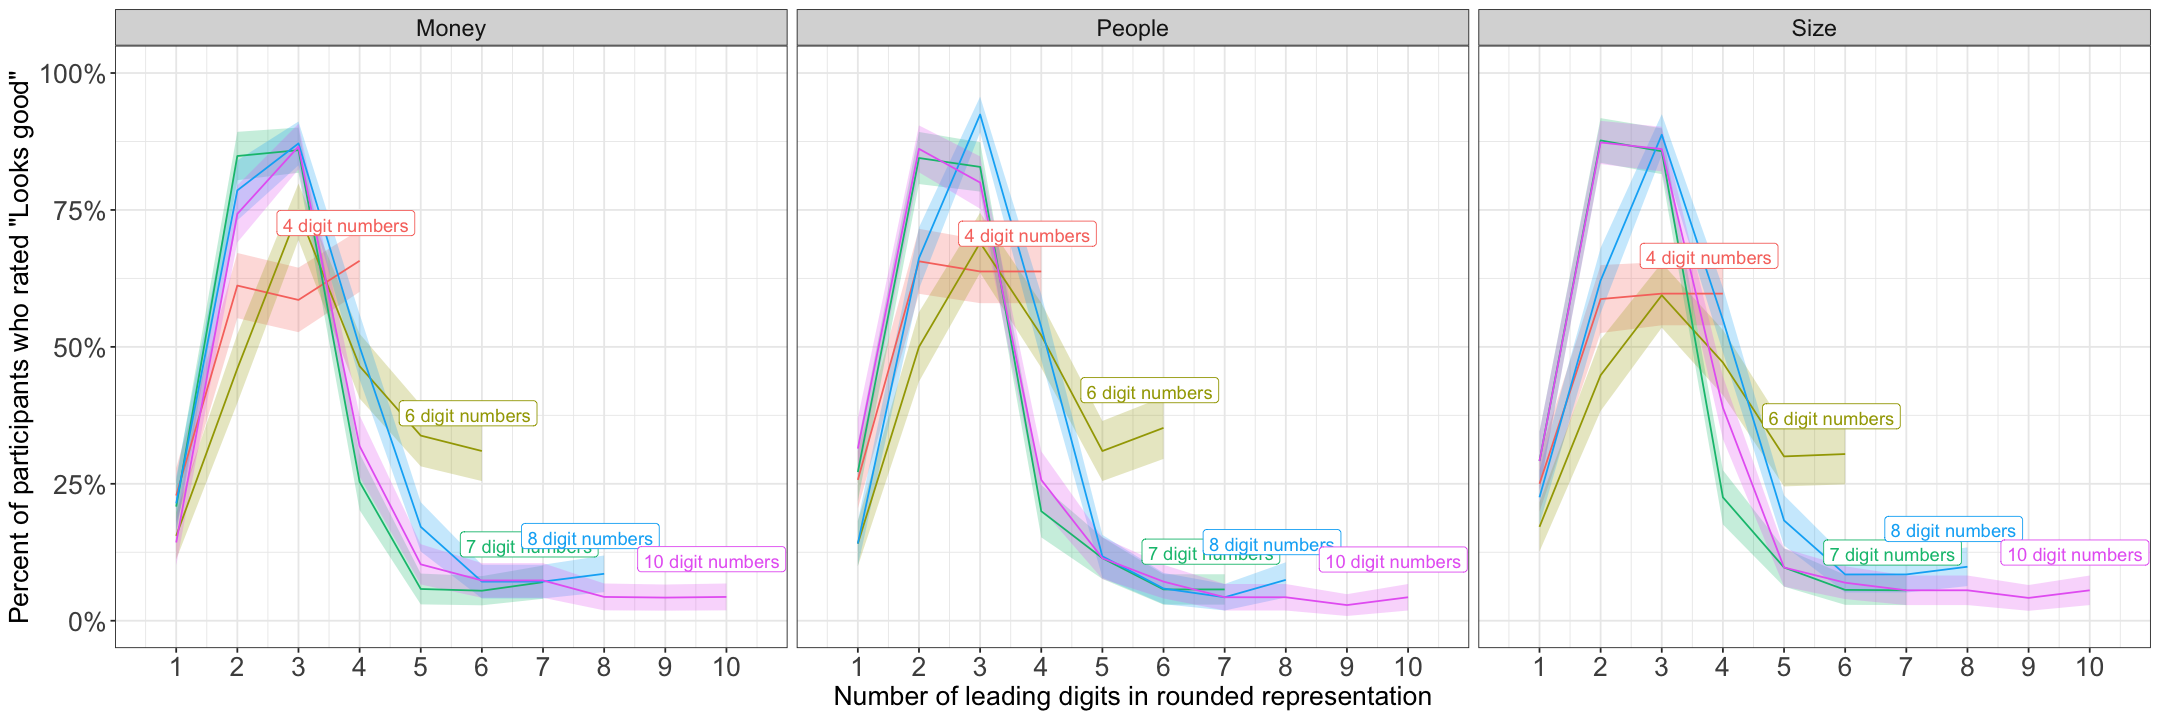

In [11]:
plot_data <- df_long %>%
    mutate(
        full_length = as.factor(full_length),
        context = get_sentence_context(template)) %>%
    group_by(prefix_length, full_length, context) %>%
    summarize(count = n(),
            frac_looks_good = mean(rating == 2),
            se = sqrt(frac_looks_good * (1 - frac_looks_good) / n()))

label_data <- plot_data %>%
    group_by(full_length, context) %>%
    filter(prefix_length == full_length) %>%
    ungroup(full_length) %>%
    mutate(label = sprintf('%s digit numbers', full_length),
         full_length = as.integer(as.character(full_length)))

options(repr.plot.width = 18, repr.plot.height = 6)
ggplot(plot_data, aes(x = prefix_length, y = frac_looks_good)) +
    geom_ribbon(aes(ymin = frac_looks_good - se, ymax = frac_looks_good + se, fill = full_length), alpha = 0.25) +
    geom_line(aes(color = full_length)) +
    geom_label(data = label_data, aes(x = full_length, y = frac_looks_good, label = label, color = as.factor(full_length)), hjust = 0.6, vjust = -1) +
    scale_y_continuous(label = percent, lim = c(0,1)) +
    scale_x_continuous(breaks = 1:10, lim = c(0.5, 10.5)) +
    text_setting() + 
    labs(x = 'Number of leading digits in rounded representation',
       y = 'Percent of participants who rated "Looks good"') +
    facet_wrap(~ context, nrow = 1) +
    theme(legend.position = "none", strip.text.x = element_text(size = 14))
ggsave(filename = 'figures/looks_good_linegraphs.png', width = 18, height = 6)

### Switching threshold from "Too precise" to "Looks good" and from "Looks good" to "Too round"

In [12]:
find_prefix_length_last_occurrence <- function(task_ratings, prefix_lengths, rating_value = 2) {
    compare = which(task_ratings == rating_value)
    if (length(compare) > 0) {
        prefix_lengths[tail(compare, n = 1)]
    } else {
        NA
    }
}

df_switch <- df_long %>%
    group_by(hit_id, assignment_id, worker_id, task_index) %>% 
    summarize(
        last_looks_good_prefix_length = find_prefix_length_last_occurrence(rating, prefix_length, 2),
        last_too_round_prefix_length = find_prefix_length_last_occurrence(rating, prefix_length, 3),
        full_length = min(full_length)
    ) %>%
    filter(!is.na(last_looks_good_prefix_length))

`summarise()` has grouped output by 'hit_id', 'assignment_id', 'worker_id'. You can override using the `.groups` argument.



Joining, by = "full_length"

Warning message:
“Removed 2 rows containing missing values (geom_text).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


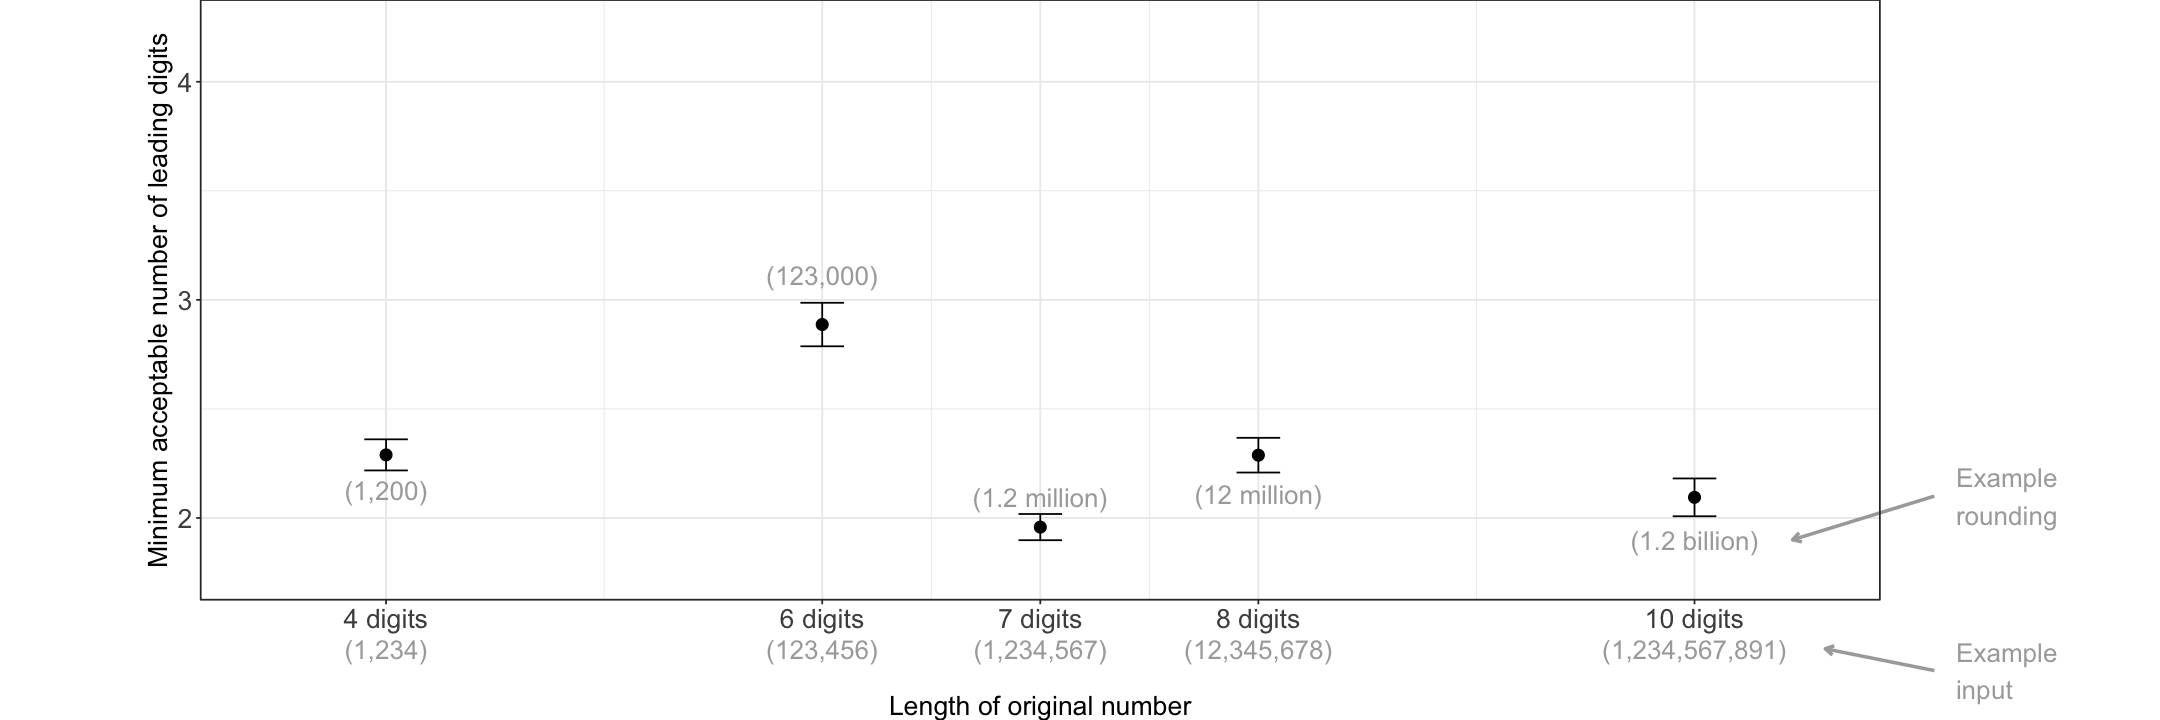

In [13]:
plot_data <- df_switch %>% 
    filter(!is.na(last_looks_good_prefix_length)) %>% 
    group_by(full_length) %>% summarize(
        mu = mean(last_looks_good_prefix_length),
        sd = sqrt(var(last_looks_good_prefix_length)),
        se = sd / sqrt(n())
    )

labels <- tribble(
    ~full_length, ~example_precise, ~example_round, ~offset,
    4, "1,234", "(1,200)", -1,
    NA, NA, NA, NA, #"12,345", NA, NA,
    6, "123,456", "(123,000)", 1,
    7, "1,234,567", "(1.2 million)", 1,
    8, "12,345,678", "(12 million)", -1,
    NA, NA, NA, NA, #"123,456,789", NA, NA,
    10, "1,234,567,891", "(1.2 billion)", -1
    ) %>%
    left_join(plot_data) %>%
    mutate(xlabel = sprintf('%s digits', ifelse(is.na(full_length), "", as.character(full_length))),
           xexample = ifelse(is.na(example_precise), "", sprintf('(%s)', example_precise)),
           y = mu + 2.25*offset*se)

ggplot(plot_data, aes(x = full_length, y = mu, ymax = mu + se, ymin = mu - se)) +
    geom_point(size = 3) +
    geom_errorbar(width = .2) +
    geom_text(data = labels, aes(x = full_length, y = y, label = example_round), size = 5.5, color = "darkgrey") +
    geom_text(data = labels, aes(x = full_length, label = xexample), y = 1.4, size = 5.5, color = "darkgrey") +
    scale_x_continuous(breaks = labels$full_length, labels = labels$xlabel) +
    scale_y_continuous(breaks = 1:4) +
    annotate("text", x = 11.2, y = 2.1, label = "Example\nrounding", size = 5.5, color = "darkgrey", hjust = 0, fontface = 1) +
    annotate("segment", x = 11.1, xend = 10.45, y = 2.1, yend = 1.9, color = "darkgrey",
             arrow = arrow(ends = "last", length = unit(.2,"cm")), size = 1.0) +
    annotate("text", x = 11.2, y = 1.3, label = "Example\ninput", size = 5.5, color = "darkgrey", hjust = 0, fontface = 1) +
    annotate("segment", x = 11.1, xend = 10.6, y = 1.3, yend = 1.4, color = "darkgrey",
             arrow = arrow(ends = "last", length = unit(.2,"cm")), size = 1.0) +
    coord_equal(xlim = c(3.5, 10.5), ylim = c(1.75, 4.25), clip = "off") +
    text_setting() +
    labs(x = '\n\nLength of original number', y = 'Minimum acceptable number of leading digits') +
    theme(plot.margin = margin(t = 0, r = 7.5, b = 0, l = 2, unit = "lines"))
ggsave(filename = 'figures/min_acceptable_precision_level_dist_with_examples.png', width = 15, height = 10)

Joining, by = c("full_length", "mu", "sd", "se")



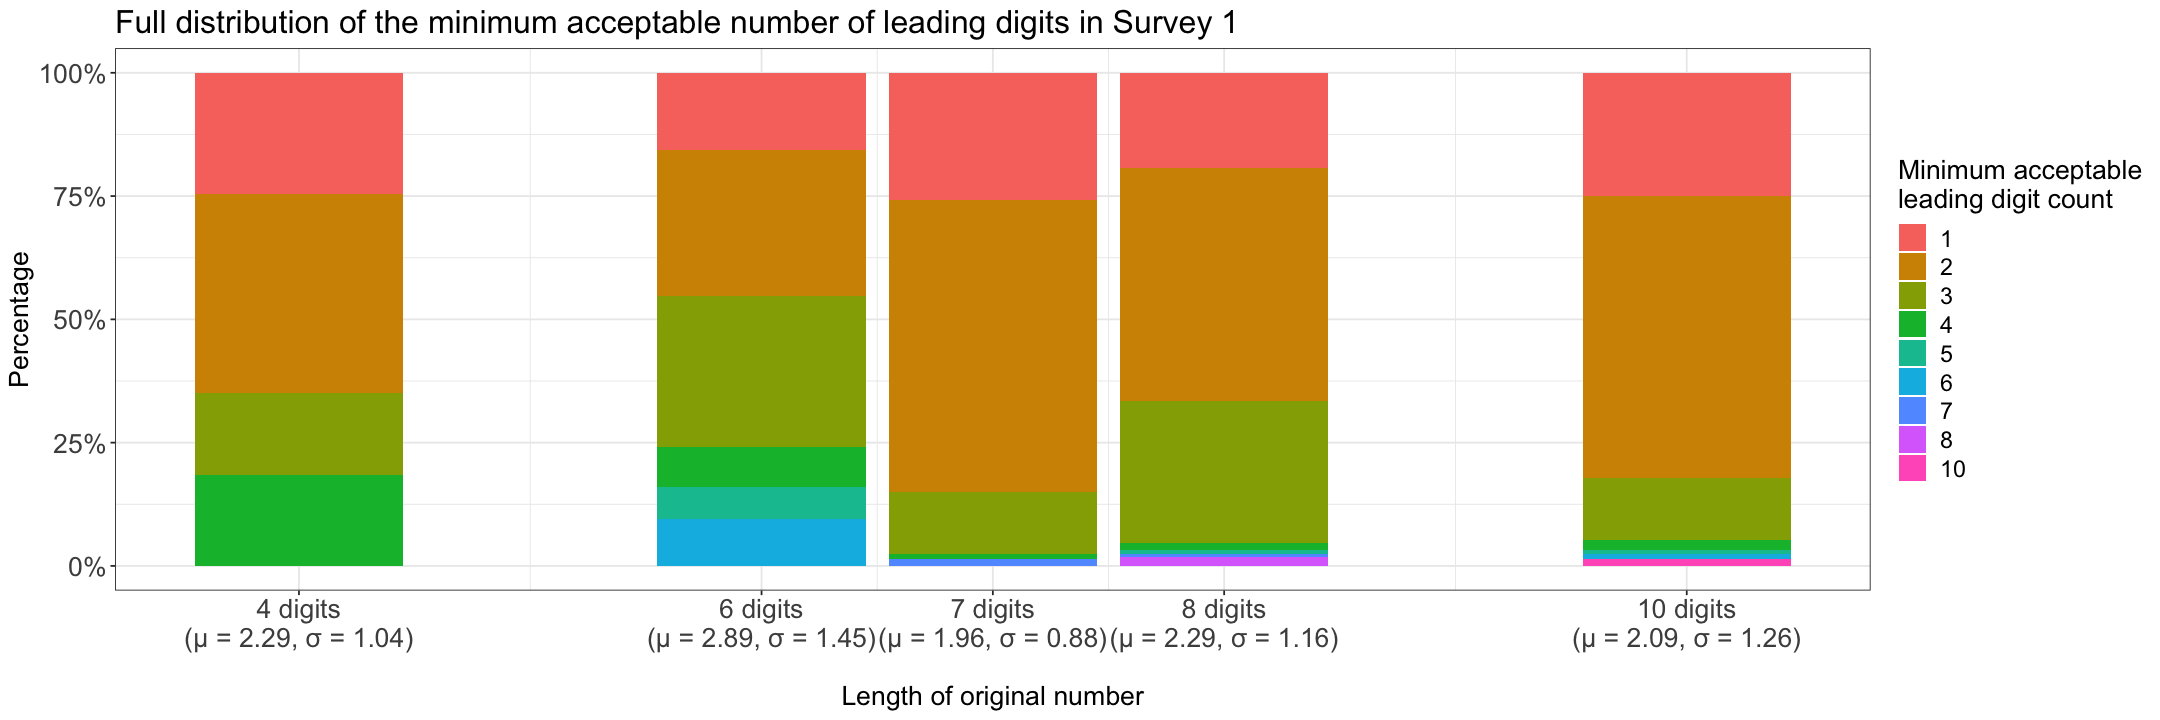

In [14]:
construct_label_distplot <- function(xlabel, mu_value, sd_value) {
    sprintf("%s\n(\U03BC = %.2f, \U03C3 = %.2f)\n", xlabel, mu_value, sd_value)
}

construct_label_distplot <- Vectorize(construct_label_distplot)

plot_data <- plot_data %>%
    left_join(labels) %>%
    mutate(distplot_xlabel = construct_label_distplot(xlabel, mu, sd))

options(warn = -1)
df_switch %>%
    group_by(full_length, last_looks_good_prefix_length) %>%
    count(last_looks_good_prefix_length) %>%
    group_by(full_length) %>%
    mutate(percent = n / sum(n)) %>%
    arrange(full_length, last_looks_good_prefix_length) %>%
    mutate(last_looks_good_prefix_length = as.factor(last_looks_good_prefix_length)) %>%
    ggplot(aes(x = full_length, y = percent, fill = last_looks_good_prefix_length)) +
    geom_bar(position = "stack", stat = "identity") +
    text_setting() +
    theme(legend.text = element_text(size = 14)) +
    scale_x_continuous(breaks = plot_data$full_length, labels = plot_data$distplot_xlabel) +
    scale_y_continuous(label = percent, lim = c(0, 1)) +
    scale_fill_discrete(name = "Minimum acceptable\nleading digit count") +
    labs(
        x = 'Length of original number',
        y = 'Percentage',
        title = "Full distribution of the minimum acceptable number of leading digits in Survey 1"
    )

ggsave("figures/survey1_full_rating_distribution.png", width = 18, height = 6)
options(warn = 0)

## Additional Analyses

### Is 5 special as a last leading digit?

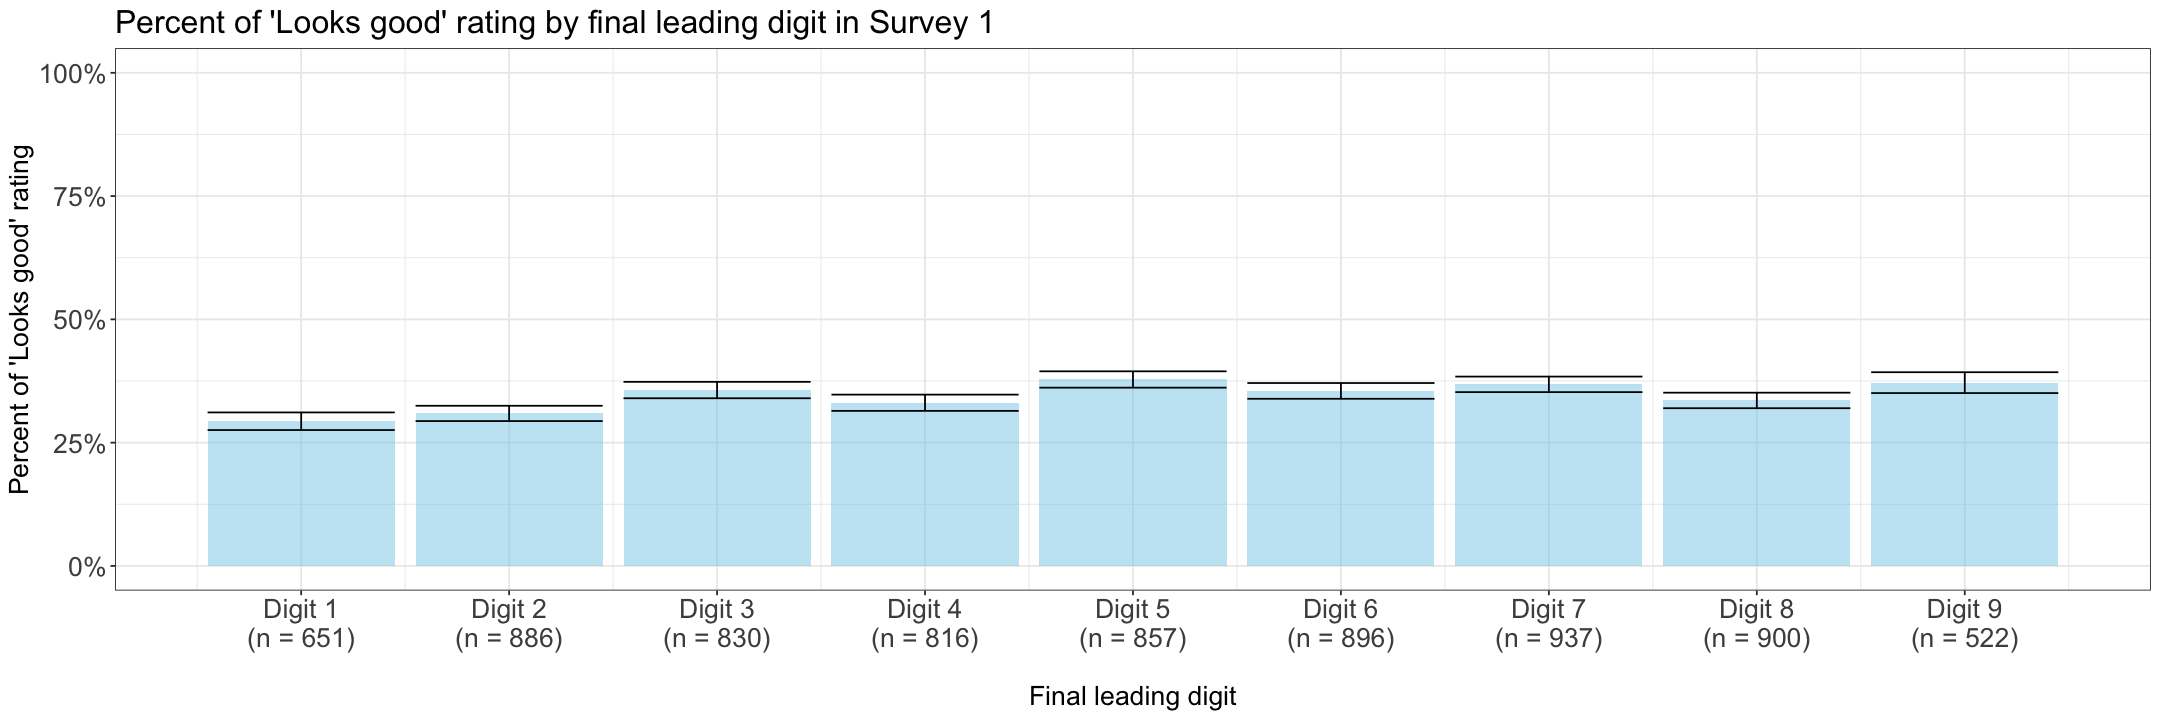

In [15]:
plot_data <- df_long %>%
    mutate(last_leading_digit = substr(prefix, prefix_length, prefix_length) %>% as.integer()) %>%
    group_by(last_leading_digit) %>%
    summarize(
        count = n(),
        frac = sum(rating == 2) / count,
        se = sqrt(frac * (1 - frac) / count),
        lower = frac - se,
        upper = frac + se
    ) %>%
    mutate(label = mapply(sprintf, "Digit %s\n(n = %d)\n", last_leading_digit, count))

plot_data %>%
    ggplot(aes(x = last_leading_digit, y = frac)) +
    geom_bar(stat = "identity", fill = "skyblue", alpha = 0.5) +
    geom_errorbar(aes(x = last_leading_digit, ymin = lower, ymax = upper)) +
    scale_x_continuous(breaks = plot_data$last_leading_digit, labels = plot_data$label) +
    scale_y_continuous(label = percent, lim = c(0,1)) +
    text_setting() +
    labs(x = "Final leading digit", y = "Percent of 'Looks good' rating", title = "Percent of 'Looks good' rating by final leading digit in Survey 1") +

ggsave(filename = "figures/survey1_pct_looks_good_by_final_digit.png", width = 15, height = 10)